## Pré-processamento

In [1]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import string
from sklearn.model_selection import train_test_split
#import spacy

df = pd.read_csv('factnews_dataset.csv')

#criar grupo treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

stop_words = set(stopwords.words('portuguese'))

#criar coluna tokens
train_df['tokens'] = train_df['sentences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))

# Tokenizar sem stopwords
train_df['tokens'] = train_df['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words])

#tirar exemplos da classe 0 para nivelar
classe0 = train_df[train_df['classe'] == 0]
classe0 = classe0.sample(n=443, random_state=42)
outras_classes = train_df[train_df['classe'] != 0]
train_df = pd.concat([outras_classes, classe0]).reset_index(drop=True)
print(train_df['classe'].value_counts())


c:\Users\didia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


classe
-1    1115
 1     443
 0     443
Name: count, dtype: int64


## Análise exploratória

Detetar palavras únicas entre as classes

In [2]:
classes = df['classe'].unique()

def palavras_unicas_por_classe(df, token_col):
    
    # contar tokens por classe
    tokens_por_classe = {}
    for classe in classes:
        linhas_classe = df[df['classe'] == classe][token_col].dropna()
        contagem = {}
        for lista in linhas_classe:
            for token in lista:
                if token in contagem:
                    contagem[token] += 1
                else:
                    contagem[token] = 1
        tokens_por_classe[classe] = contagem

    # detetar palavras exclusivas por classe
    palavras_unicas = {}
    for classe in classes:
        # lista de palavras das outras classes
        outras_palavras = []
        for outra_classe in classes:
            if outra_classe != classe:
                for token in tokens_por_classe[outra_classe]:
                    outras_palavras.append(token)

        # dicionário palavras exclusivas com contagens
        unicas_classe = {}
        for palavra, contagem in tokens_por_classe[classe].items():
            exclusiva = True
            for p in outras_palavras:
                if p == palavra:
                    exclusiva = False
                    break
            if exclusiva:
                unicas_classe[palavra] = contagem

        palavras_unicas[classe] = unicas_classe

        #manter as 10 mais comuns em cada classe
        ordenadas = dict(sorted(unicas_classe.items(), key=lambda item: item[1], reverse=True)[:10])

        palavras_unicas[classe] = ordenadas

    return palavras_unicas

print(palavras_unicas_por_classe(train_df,'tokens'))


{-1: {']': 48, '[': 47, 'gente': 33, 'vamos': 20, '...': 19, '!': 18, 'povo': 18, 'coisa': 14, 'nada': 13, 'quero': 12}, 0: {'presos': 7, 'negou': 5, 'defende': 5, 'm': 5, 'posse': 5, 'irá': 4, 'principais': 4, 'lista': 4, 'oficial': 4, 'crimes': 4}, 1: {'maracanã': 9, 'kaká': 7, 'chinaglia': 6, 'atacante': 6, 'vagner': 5, 'ronaldinho': 5, 'marcação': 5, 'desgaste': 5, 'escolha': 4, 'bolsonarista': 4}}


ver a proporção de advérbios e adjetivos entre as classes

In [3]:
nltk.download('mac_morpho') 
from nltk.corpus import mac_morpho

dic_palavras = {}  # Dic para palavras de cada classe gramatical
for palavra, tag in mac_morpho.tagged_words():  # (palavra, tag)
    if tag not in dic_palavras: 
        dic_palavras[tag] = set()
    dic_palavras[tag].add(palavra.lower())  # associar palavra à respetiva tag

print (dic_palavras)

[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\didia\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


{'N': {'munição', 'nulo', 'abusos', 'mulata', 'esterelização', 'seletivo', 'incógnita', 'tristeza', 'porção', 'trauma', 'corporativo', 'superiores', 'bouvier', 'frase-título', 'pinóia', 'retrospecto', 'genências', 'tigres', 'lema', 'pujança', 'agora', 'narração', 'comandantes', 'pencas', 'clumber', 'supertimes', 'complementação', 'falha', 'revolucionário', 'radicalização', 'anistia', 'blues', 'seda', 'máfia', 'demos', 'anões', 'prerrogativa', 'carnaúba', 'mentiras', 'cabriolas', 'frigorífico', 'cápsula', 'especulação', 'classes', 'inviabilidade', 'boas', 'fria', 'clareza', 'história', 'sociais', 'gigabytes', 'esclarecimento', 'melhora', 'alho', 'autarquia', 'durão', 'uísque', 'inelegibilidade', 'entrevistas', 'reputações', 'retribuição', 'quociente', '20.813', 'décimo', 'fissco', 'silogismo', 'retroescavadeiras', 'nocauteados', 'peessebistas', 'vigias', 'aztecas', 'expectador', 'projetos', 'assassino', 'vendeano', 'esperanças', 'garantias', 'mediação', 'estampas', 'particularidade', 'f

Ver todos os tipos de token presentes no dataset

In [4]:
print(dic_palavras.keys())

dict_keys(['N', 'V', 'PREP', 'CUR', 'NUM', 'PREP|+', 'ART', 'NPROP', 'PROADJ', ',', 'PRO-KS-REL', 'N|AP', 'ADJ', 'KC', 'VAUX', '(', ')', 'KS', '"', 'PCP', 'ADV', 'PROPESS', 'V|+', 'PDEN', 'PROSUB', '-', ':', 'PRO-KS', 'VAUX|+', 'ADV-KS-REL', '$', 'N|HOR', ';', 'ART|+', '[', 'ADJ|EST', 'N|EST', 'N|TEL', 'N|DAT', 'KC|[', 'KC|]', '?', '!', 'ADV|[', 'ADV|]', 'ADV-KS', 'ADV|+', 'NUM|TEL', '.', 'IN', "'", '/', 'PREP|[', 'PREP|]', 'NPROP|+', 'PREP|', 'NPRO', 'ADV|EST', '...', 'N|DAD', '=', 'VAUX|!', 'ADV|HOR', 'ADJ|+', 'ART|EST', 'PREP|+]', 'PROP', 'V|EST', 'PREP|EST', 'KC|EST', 'PROADJ|+', 'KS|[', 'KS|]', 'IN|EST', 'PROPESS|EST', 'PDEN|EST', '((', '))', '`', 'PROPESS|+', 'KC|+', 'V|!'])


In [5]:
def proporcao_adverbios_adjetivos_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()  
    proporcoes_por_classe = {}     

    lista_adverbios = dic_palavras.get('ADV', set())  
    lista_adjetivos = dic_palavras.get('ADJ', set())  
    lista_modais = dic_palavras.get('MD', set())
    
    for classe in classes: 
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()  
            
        total_adverbios_classe = 0   
        total_adjetivos_classe = 0    
        total_modais_classe = 0
        total_tokens_classe = 0

        # contar advérbios e adjetivos
        for lista_tokens in tokens_por_classe:
            total_adverbios_classe += sum(1 for token in lista_tokens if token in lista_adverbios)
            total_adjetivos_classe += sum(1 for token in lista_tokens if token in lista_adjetivos)
            total_modais_classe += sum(1 for token in lista_tokens if token in lista_modais)
            total_tokens_classe += len(lista_tokens)

        proporcoes_por_classe[classe] = {
            'total_adverbios': total_adverbios_classe,
            'media_adverbios_por_token': total_adverbios_classe / total_tokens_classe,
            'total_adjetivos': total_adjetivos_classe,
            'media_adjetivos_por_token': total_adjetivos_classe / total_tokens_classe,
            'total_modais': total_modais_classe,
            'media_modais_por_token': total_modais_classe / total_tokens_classe,
        }
    
    return proporcoes_por_classe

proporcao_adverbios_adjetivos_por_classe(train_df, 'tokens')

{-1: {'total_adverbios': 1089,
  'media_adverbios_por_token': 0.07324947871123966,
  'total_adjetivos': 1788,
  'media_adjetivos_por_token': 0.12026636174076814,
  'total_modais': 0,
  'media_modais_por_token': 0.0},
 1: {'total_adverbios': 527,
  'media_adverbios_por_token': 0.07272978194866134,
  'total_adjetivos': 1047,
  'media_adjetivos_por_token': 0.14449351366271046,
  'total_modais': 0,
  'media_modais_por_token': 0.0},
 0: {'total_adverbios': 446,
  'media_adverbios_por_token': 0.06315491362220334,
  'total_adjetivos': 937,
  'media_adjetivos_por_token': 0.13268195978476352,
  'total_modais': 0,
  'media_modais_por_token': 0.0}}

In [6]:
def proporcao_palavras_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()
    proporcoes_por_classe = {}

    for classe in classes:
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()
        total_tokens_classe = sum(len(lista) for lista in tokens_por_classe)
        proporcoes_por_classe[classe] = {}

        for key in dic_palavras.keys():
            lista_tokens_tag = dic_palavras.get(key, set())
            total_palavras_tag = sum(
                1 for lista_tokens in tokens_por_classe for token in lista_tokens if token in lista_tokens_tag
            )
            if total_palavras_tag > 0:
                proporcoes_por_classe[classe][key] = {
                    'total': total_palavras_tag,
                    'media_por_token': total_palavras_tag / total_tokens_classe if total_tokens_classe else 0
                }

    return proporcoes_por_classe

resultados = proporcao_palavras_por_classe(train_df, 'tokens')

discrepancias = {}

for key in dic_palavras.keys():
    media_0 = resultados.get(0, {}).get(key, {}).get('media_por_token', 0)
    media_1 = resultados.get(1, {}).get(key, {}).get('media_por_token', 0)
    discrepancia = abs(media_0 - media_1)
    discrepancias[key] = (discrepancia, media_0, media_1)

chaves_ordenadas = sorted(discrepancias, key=lambda k: discrepancias[k][0], reverse=True)[:10]

for k in chaves_ordenadas:
    discrepancia, media_0, media_1 = discrepancias[k]
    print(f"{k}: classe 0 = {media_0:.4f}, classe 1 = {media_1:.4f}, diferença = {discrepancia:.4f}")

print(chaves_ordenadas)


NPROP: classe 0 = 0.5861, classe 1 = 0.5381, diferença = 0.0480
V: classe 0 = 0.2251, classe 1 = 0.2563, diferença = 0.0311
NUM: classe 0 = 0.0384, classe 1 = 0.0204, diferença = 0.0179
N|AP: classe 0 = 0.0375, classe 1 = 0.0210, diferença = 0.0165
ADJ: classe 0 = 0.1327, classe 1 = 0.1445, diferença = 0.0118
ADV: classe 0 = 0.0632, classe 1 = 0.0727, diferença = 0.0096
V|+: classe 0 = 0.0351, classe 1 = 0.0446, diferença = 0.0095
N: classe 0 = 0.4810, classe 1 = 0.4720, diferença = 0.0090
VAUX: classe 0 = 0.0265, classe 1 = 0.0335, diferença = 0.0071
(: classe 0 = 0.0160, classe 1 = 0.0104, diferença = 0.0057
['NPROP', 'V', 'NUM', 'N|AP', 'ADJ', 'ADV', 'V|+', 'N', 'VAUX', '(']


ver distruibuição de classes gramaticais por frase entre classe

In [16]:
import spacy
import pandas as pd

nlp = spacy.load("pt_core_news_sm")

def analise_distribuicao_pos_por_frase(df):
    classes = df['classe'].unique()
    resultados = {}
    
    for classe in classes:
        tokens = df[df['classe'] == classe]['tokens']
        total_frases = len(tokens)
    
        dic_contagens = {}
        
        for frase in tokens:
            frase = ' '.join(frase)
            texto = nlp(frase)

            for elem in texto:
                categoria = elem.pos_

                if categoria not in dic_contagens.keys():
                    dic_contagens[categoria]=1
                else:
                    dic_contagens[categoria] += 1
        
        #média por frases
        dic_medias = {}
        for chave, valor in dic_contagens.items():
            dic_medias[chave] = valor / total_frases
        
        resultados[classe]= dic_medias

    return resultados
    
distribuicao_por_frase = analise_distribuicao_pos_por_frase(train_df)


diferenças na distribuição entre a classe 0 e 1

In [ ]:
def diferenca_classes(dic_medias):
    diferencas={}
    cat_comuns = set(dic_medias[0].keys()) & set(dic_medias[1].keys())
    for categoria  in cat_comuns:
        dif = dic_medias[0].get(categoria) - dic_medias [1].get(categoria)
        diferencas[categoria]=dif
        diferencas = dict(sorted(diferencas.items(), key=lambda x: abs(x[1]), reverse=True))
    return diferencas

dif= diferenca_classes(distribuicao_por_frase)



{'VERB': -0.5553047404063207,
 'ADJ': -0.41986455981941306,
 'NUM': 0.37471783295711064,
 'NOUN': -0.23250564334085855,
 'PROPN': 0.20541760722347635,
 'PUNCT': 0.16252821670428919,
 'SYM': 0.13769751693002258,
 'ADV': -0.1309255079006772,
 'ADP': 0.07900677200902939,
 'AUX': 0.04063205417607224,
 'DET': -0.024830699774266357,
 'PRON': -0.020316027088036114,
 'SCONJ': -0.011286681715575623,
 'X': -0.009029345372460498,
 'CCONJ': 0.0022573363431151235}

## Contruir regras para classificar o texto

Classificar Versão 1

In [9]:
def citacao(text):
    return '"' in str(text) or '“' in str(text) or '”' in str(text) or '[' in str(text) 

def bias(text):
    return '?' in str(text)

def classificar(row):
    if citacao(row['sentences']):
        return -1  
    if bias(row['sentences']):
        return 1
    return 0

Classificar Versão 2

In [ ]:
def classificar_frase(data, diferencas): 
    contagens_frase={}
    
    for frase in data['setences']:
        texto= nlp(frase)

    for token in texto:
        categoria = token.pos_
        contagens_frase[categoria] = contagens_frase.get(categoria, 0) + 1

    categorias = diferencas.keys()
    score = 0
    for categoria in categorias:
        if categoria in contagens_frase:
            score += contagens_frase[categoria] * dif[categoria]
    
    if score > 0 :
        return 1
    else:
        return 0


In [10]:
palavras_unicas = palavras_unicas_por_classe(train_df,'tokens')

def classificar_texto(row):
    texto = row['sentences'].lower()
    tokens_texto = nltk.word_tokenize(texto)
    tokens_set = set(tokens_texto)

    for classe, palavras_contagem in palavras_unicas.items():
        for palavra in palavras_contagem.keys():
            if palavra in tokens_set: 
                return classe

    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }
    #citacao
    if '"' in texto or '“' in texto or '”' in texto or "'" in texto or "[" in texto:
        return -1
    if any(verbo in texto for verbo in ['disse', 'afirmou', 'relatou', 'segundo', 'comentou']):
        pontos['citacao'] += 1
        

    #bias
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {
        'citacao': -1,
        'facto': 0,
        'bias': 1,
    }
    
    return mapa_classes[classe_max]


Classificar Versão 3

In [11]:
import spacy
import re

nlp = spacy.load("pt_core_news_sm")

def classificar_texto2(row, medias, chaves):
    texto = row['sentences'].lower()
    doc = nlp(texto)
    tags = [token.pos_ for token in doc]
    total_tokens = len(tags) 
    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }

    # Citacao
    if any(p in texto for p in ['"', '“', '”', "'", '[']):
        pontos['citacao'] += 2

    # Bias - estas regras de palavras podemos substituir pelas palavras unicas
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #a cena das médias
    for key in chaves:
        media_0 = medias.get(0, {}).get(key, {}).get('media_por_token', 0)
        media_1 = medias.get(1, {}).get(key, {}).get('media_por_token', 0)
        meio = (media_0 + media_1) / 2

        valor_frase = tags.count(key) / total_tokens

        if valor_frase >= meio:
            if media_0 < media_1:   
                pontos['bias'] += 1
            else:
                pontos['facto'] += 1 
        else:
            if media_1 < media_0:
                pontos['facto'] += 1
            else:
                pontos['bias'] += 1
    # Factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {'citacao': -1, 'facto': 0, 'bias': 1}
    return mapa_classes[classe_max]


ver verbo verbo numa frase - prob um bias

## Aplicar classificação no conjunto de teste

In [ ]:
test_df['Previsto'] = test_df.apply(classificar, axis=1)
test_df['Previsto2'] = test_df.apply(classificar_texto, axis=1)
test_df['Previsto3'] = test_df.apply(classificar_texto2, axis=1, args=(resultados, chaves_ordenadas))


AttributeError: 'float' object has no attribute 'get'

## Avaliar as regras de classificação

In [ ]:
print(test_df[['sentences', 'classe', 'Previsto', 'Previsto2']].head())

                                              sentences  classe  Previsto  \
996   No primeiro turno, o candidato da esquerda chi...       0         0   
468   Esta é a segunda vez em menos de um ano que o ...       0         0   
6077  A margem de erro é dois pontos para mais ou pa...       0         0   
2127  Passei um dia na cidade nesta semana -moro no ...      -1         0   
2080  Na ocasião, o peemedebista discordou dos outro...       0         0   

      Previsto2  
996          -1  
468           0  
6077         -1  
2127         -1  
2080         -1  


Certos: 969 de 1239
Accuracy: 78.21%
Classe -1:  65.21739130434783 %
Classe 0:  92.9245283018868 %
Classe 1:  0.8695652173913043 %


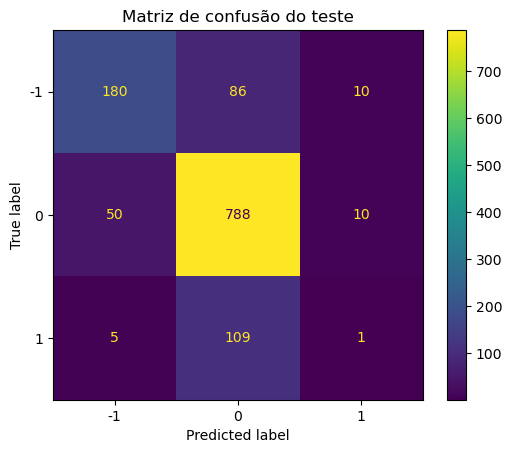

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

Certos: 504 de 1239
Accuracy: 40.68%
Classe -1:  92.7536231884058 %
Classe 0:  28.066037735849058 %
Classe 1:  8.695652173913043 %


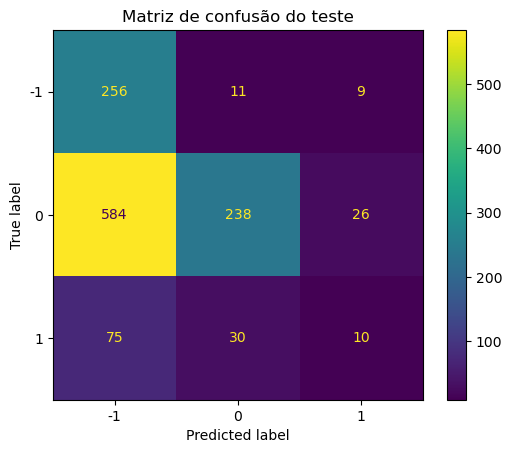

In [ ]:
certos = (test_df['classe'] == test_df['Previsto2']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto2']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto2'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

Certos: 115 de 1239
Accuracy: 9.28%
Classe -1:  0.0 %
Classe 0:  0.0 %
Classe 1:  100.0 %


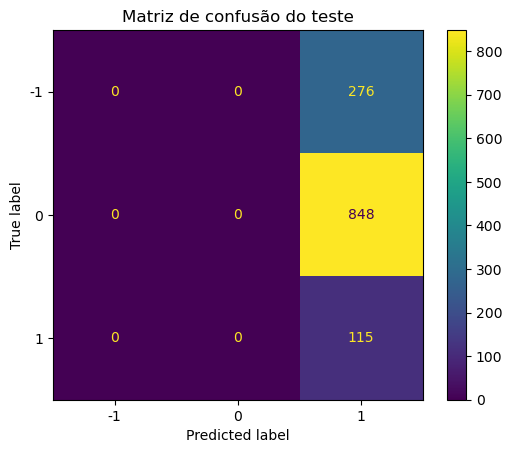

In [ ]:
certos = (test_df['classe'] == test_df['Previsto3']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto3']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto3'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()